# Librerias

In [1]:
import pandas as pd
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sys
import unicodedata
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet as wn
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from nltk.stem import WordNetLemmatizer


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\te512362\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\te512362\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Pre-procesamiento de datos

In [3]:
#Creamos una variable df con el dataset
df = pd.read_csv("haha_2021_train.csv")

In [4]:
df.drop(["votes_no","votes_1", "votes_2", "votes_3", "votes_4", "votes_5","humor_mechanism"],
          axis=1,
          inplace=True)

In [5]:
df.head()

,id,text,is_humor,humor_rating,humor_target
0,tweet1,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,1,1.5,NaN
1,tweet2,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1.5,NaN
2,tweet3,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,2.6,NaN
3,tweet4,No se porqué me hago la cabeza deooos,0,NaN,NaN
4,tweet5,Quisiera saber que hago durante la siesta de l...,0,NaN,NaN


In [6]:
df.text.isnull().any() # no missing values in is_sarcastic column
df.is_humor.isnull().any() # no missing values in headline column

False

In [7]:
df['text'] = df.text.apply(lambda x:x.lower())  # convert all words in text into lower case 
df['text'] = df.text.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuation 

In [8]:
df.head()

,id,text,is_humor,humor_rating,humor_target
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,1.5,NaN
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,1.5,NaN
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,2.6,NaN
3,tweet4,no se porqué me hago la cabeza deooos,0,NaN,NaN
4,tweet5,quisiera saber que hago durante la siesta de l...,0,NaN,NaN


In [9]:
df = df.assign(CleanText="", TokenizeText="", NoStopwords="", LemmaText="")

In [94]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

df['CleanText'] = df['text'].str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


In [95]:
def Tokenizacion(tweet):
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)
  return tweet_tokens



In [96]:
for i in range(len(df)):
  df['TokenizeText'][i] = Tokenizacion(df['CleanText'][i])

c:\Users\te512362\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
#Concatenar las stopwords aplicándose a una cuenta que genera contenido en inglés y español
stop_words = stop_words_sp | stop_words_en

In [98]:
df['NoStopwords'] = df['TokenizeText'].apply(lambda x: [item for item in x if item not in stop_words])

In [99]:
df.head()

,id,text,is_humor,humor_rating,humor_target,CleanText,TokenizeText,NoStopwords,LemmaText
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,1.5,NaN,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...","[niveles, retraso, mental, bajo, medio, alto, ..."
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,1.5,NaN,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...","[vamos, luke, desenfunda, sable, demuestra, od..."
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,2.6,NaN,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...","[ofrezco, agua, café, corazón, vida, enteron, ..."
3,tweet4,no se porqué me hago la cabeza deooos,0,NaN,NaN,no se porqué me hago la cabeza deooos,"[no, se, porqué, me, hago, la, cabeza, deooos]","[porqué, hago, cabeza, deooos]","[porqué, hago, cabeza, deooos]"
4,tweet5,quisiera saber que hago durante la siesta de l...,0,NaN,NaN,quisiera saber que hago durante la siesta de l...,"[quisiera, saber, que, hago, durante, la, sies...","[quisiera, saber, hago, siesta, levanto, cansa...","[quisiera, saber, hago, siesta, levanto, cansa..."


In [16]:
import nltk
from nltk.stem import WordNetLemmatizer

In [17]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\te512362\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()

df['LemmaText'] = df['NoStopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 


In [19]:
df2 = df[df['humor_target'].isna() != True]

In [20]:
topicos = np.unique(df2['humor_target'])

In [21]:
topics = []
for element in topicos:
    if element not in topics:
        topics.append(element)

In [22]:
len(topics)

53

In [23]:
dfLDA = df[df['humor_rating'].isna() != True]

In [24]:
dfLDA['humor_rating'] = dfLDA['humor_rating'].round()
dfLDA['humor_rating'] = np.array(dfLDA['humor_rating'], dtype=np.int)

c:\Users\te512362\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\te512362\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
dfLDA.head()

,id,text,is_humor,humor_rating,humor_target,CleanText,TokenizeText,NoStopwords,LemmaText
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,2,NaN,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...","[niveles, retraso, mental, bajo, medio, alto, ..."
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,2,NaN,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...","[vamos, luke, desenfunda, sable, demuestra, od..."
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,3,NaN,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...","[ofrezco, agua, café, corazón, vida, enteron, ..."
6,tweet7,—buenas don pepe ¿me vende un litro de leche —...,1,2,NaN,buenas don pepe me vende un litro de leche ent...,"[buenas, don, pepe, me, vende, un, litro, de, ...","[buenas, pepe, vende, litro, leche, entera, si...","[buenas, pepe, vende, litro, leche, enteron, s..."
12,tweet13,20cosasquehacerantesdemorir enseñarles la dife...,1,3,NaN,20cosasquehacerantesdemorir enseñarles la dife...,"[20cosasquehacerantesdemorir, enseñarles, la, ...","[20cosasquehacerantesdemorir, enseñarles, dife...","[20cosasquehacerantesdemorir, enseñarles, dife..."


# MLFlow & LDA

In [26]:
import mlflow
import mlflow.sklearn
track_uri = "http://localhost:5000/" # Esto puede ser que cambie por http://0.0.0.0:1234
mlflow.set_tracking_uri(track_uri)
mlflow.set_registry_uri("sqlite:////tmp/registry.db")


c:\Users\te512362\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  """Entry point for launching an IPython kernel.


In [27]:
# Generando el experimento o cargandolo si existe
experiment_name = "LDA"
mlflow.set_experiment(experiment_name)

# Cargando la información
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id


# Vamos a ver si es cierto
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 1.23.1
Tracking URI: http://localhost:5000/
Nombre del experimento: LDA
ID del experimento: 1


In [28]:
import pickle

In [84]:
mlflow.sklearn.autolog()
paramsVec = {"analyzer":"word","ngram_range": (2,2)}

# initialise the count vectorizer
vectorizer = CountVectorizer(**(paramsVec))       

with open('Vectorize.pkl', 'wb') as file:  
    pickle.dump(vectorizer, file)          
# join the processed data to be vectorised no_stopwords
vectors = []
for index, row in df.iterrows():
    vectors.append(", ".join(row[8]))
vectorised = vectorizer.fit_transform(vectors)


params = {'n_components':10,'random_state':10,'evaluate_every':-1,'n_jobs':-1}
mlflow.log_params(paramsVec)
mlflow.log_params(params)
mlflow.log_artifact("Vectorize.pkl", "Vectores")


lda_model = LatentDirichletAllocation(**params)
lda_output = lda_model.fit_transform(vectorised)

mlflow.sklearn.log_model(lda_model, artifact_path="sklearn-model")

#metrics = mlflow.sklearn.eval_and_log_metrics(lda_model,vectorised, prefix="val_")
mlflow.end_run()

2022/05/18 10:18:57 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/05/18 10:18:57 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


In [85]:
# column names
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

dfLDA = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(dfLDA.head(10))

,id,text,is_humor,humor_rating,humor_target,CleanText,TokenizeText,NoStopwords,LemmaText,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Dominant_topic
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,1.5,NaN,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...","[niveles, retraso, mental, bajo, medio, alto, ...",0.01,0.01,0.01,0.90,0.01,0.01,0.01,0.01,0.01,0.01,4
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,1.5,NaN,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...","[vamos, luke, desenfunda, sable, demuestra, od...",0.01,0.01,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,3
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,2.6,NaN,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...","[ofrezco, agua, café, corazón, vida, enteron, ...",0.92,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
3,tweet4,no se porqué me hago la cabeza deooos,0,NaN,NaN,no se porqué me hago la cabeza deooos,"[no, se, porqué, me, hago, la, cabeza, deooos]","[porqué, hago, cabeza, deooos]","[porqué, hago, cabeza, deooos]",0.77,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,1
4,tweet5,quisiera saber que hago durante la siesta de l...,0,NaN,NaN,quisiera saber que hago durante la siesta de l...,"[quisiera, saber, que, hago, durante, la, sies...","[quisiera, saber, hago, siesta, levanto, cansa...","[quisiera, saber, hago, siesta, levanto, cansa...",0.01,0.01,0.01,0.01,0.01,0.89,0.01,0.01,0.01,0.01,6
5,tweet6,la persona que te dice que no se arrepiente de...,0,NaN,NaN,la persona que te dice que no se arrepiente de...,"[la, persona, que, te, dice, que, no, se, arre...","[persona, dice, arrepiente, vida, toma, alcoho...","[persona, dice, arrepiente, vida, toma, alcoho...",0.01,0.01,0.01,0.01,0.01,0.01,0.90,0.01,0.01,0.01,7
6,tweet7,—buenas don pepe ¿me vende un litro de leche —...,1,2.5,NaN,buenas don pepe me vende un litro de leche ent...,"[buenas, don, pepe, me, vende, un, litro, de, ...","[buenas, pepe, vende, litro, leche, entera, si...","[buenas, pepe, vende, litro, leche, enteron, s...",0.93,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
7,tweet8,meeee aburro,0,NaN,NaN,meeee aburro,"[meee, aburro]","[meee, aburro]","[meee, aburro]",0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,10
8,tweet9,macri le dijo las gordas que usar calzas está ...,0,NaN,NaN,macri le dijo las gordas que usar calzas está ...,"[macri, le, dijo, las, gordas, que, usar, calz...","[macri, dijo, gordas, usar, calzas, bien]","[macri, dijo, gordas, usar, calzas, bien]",0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.85,0.02,9
9,tweet10,javier chicalito hernandez 7,0,NaN,NaN,javier chicalito hernandez,"[javier, chicalito, hernandez]","[javier, chicalito, hernandez]","[javier, chicalito, hernandez]",0.03,0.03,0.70,0.03,0.03,0.03,0.03,0.03,0.03,0.03,3


In [107]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

tmp.head()

,topic,relevance_score
00 cosas,Topic10,1.100000
00 d3,Topic3,4.100014
00 dejar,Topic5,1.100000
00 dosogas,Topic10,1.100000
00 llegué,Topic9,1.100000


In [108]:
banned = ['Topic']
tmp = tmp.replace(dict(zip(banned,['']*len(banned))),regex=True)

In [109]:
tmp["topic"] = tmp["topic"].astype(int) 
tmp.head(10)

,topic,relevance_score
00 cosas,10,1.100000
00 d3,3,4.100014
00 dejar,5,1.100000
00 dosogas,10,1.100000
00 llegué,9,1.100000
00 vean,10,1.100000
0055florida seguime,9,1.100000
01 cambió,1,1.100000
01 compuesto,6,1.100000
01 fb,1,1.100000


In [110]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
all_topics.head()

,Dominant_topic,topic_name
0,11,[escribiendo escribiendo]
1,4,[si va]
2,6,[chistes humor]
3,10,[cómo llama]
4,2,[puede ser]


In [111]:
results = dfLDA.groupby(['Dominant_topic', 'is_humor']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'is_humor']]
graph_results = graph_results.pivot(index='topic_name', columns='is_humor').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

topic_name
buen día
cada vez
chistes humor
chistes rt
cómo llama
ja ja
puede ser
si va
va ser


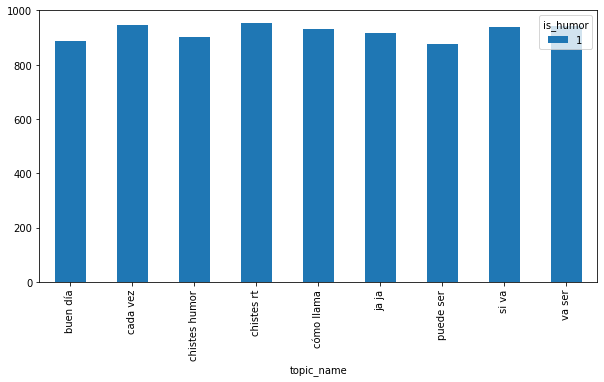

In [92]:
fig = graph_results[[1]].plot.bar(rot=90, figsize=(10,5))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight', dpi=300)